# Import Modules

In [1]:
import importlib
import os
import sys

import joblib
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
os.chdir("../")
sys.path.insert(0, os.getcwd())

In [3]:
from morai.experience import charters
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

In [4]:
logger = custom_logger.setup_logging(__name__)

In [5]:
# update log level if wanting more logging
custom_logger.set_log_level("INFO")

In [6]:
pd.options.display.float_format = "{:,.2f}".format

# Data

In [7]:
pl_parquet_path = r"files/dataset/mortality_grouped.parquet"

In [8]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
)

In [9]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count:,} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]:,}"
)

row count: 1,793,414 
exposures: 9,843,343,085,052.367


In [10]:
grouped_df = lzdf.collect()

In [11]:
grouped_df = grouped_df.to_pandas()

# Functions

In [12]:
def add_qx_exp_ae(model_data, predictions, model_name):
    model_data[f"qx_{model_name}"] = predictions
    model_data[f"exp_amt_{model_name}"] = (
        model_data[f"qx_{model_name}"] * model_data["amount_exposed"]
    )
    model_data[f"ae_{model_name}"] = np.where(
        model_data["amount_exposed"] == 0,
        0,
        np.where(
            model_data[f"exp_amt_{model_name}"] == 0,
            1,
            model_data["death_claim_amount"] / model_data[f"exp_amt_{model_name}"],
        ),
    )
    return model_data

In [13]:
def get_importance(features, values):
    importance = pd.DataFrame({"feature": features, "importance": values})
    importance = importance.sort_values(by="importance", ascending=False)
    return importance

# Preparing Data

## Filter

In [14]:
model_data = grouped_df[
    (grouped_df["attained_age"] >= 50)
    & (grouped_df["attained_age"] <= 95)
    & (grouped_df["issue_age"] >= 30)
    & (grouped_df["issue_age"] <= 80)
].copy()
model_data = model_data.reset_index(drop=True)

In [15]:
del grouped_df

## Calculated Fields

In [16]:
model_data["capped_duration"] = model_data["duration"].clip(upper=26)
model_data["qx_log_raw"] = np.log(model_data["qx_raw"] + 1)
binned_face_dict = {
    '01: 0 - 9,999': '01: 0 - 24,999',
    '02: 10,000 - 24,999': '01: 0 - 24,999',
    '03: 25,000 - 49,999': '02: 25,000 - 99,999',
    '04: 50,000 - 99,999': '02: 25,000 - 99,999',
    '05: 100,000 - 249,999': '03: 100,000 - 249,999',
    '06: 250,000 - 499,999': '04: 250,000 - 4,999,999',
    '07: 500,000 - 999,999': '04: 250,000 - 4,999,999',
    '08: 1,000,000 - 2,499,999': '04: 250,000 - 4,999,999',
    '09: 2,500,000 - 4,999,999': '04: 250,000 - 4,999,999',
    '10: 5,000,000 - 9,999,999': '05: 5,000,000+',
    '11: 10,000,000+': '05: 5,000,000+',
}
model_data['binned_face'] = model_data['face_amount_band'].map(binned_face_dict)

## Feature Dictionary

In [17]:
feature_dict = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "duration", "observation_year"],
    "ordinal": [
        "sex",
        "smoker_status",
    ],
    "ohe": [
        "binned_face",
        "insurance_plan",
        "class_enh",
    ],
    "nominal": [],
}

feature_dict_vbt = {
    "target": ["qx_raw"],
    "weight": ["amount_exposed"],
    "passthrough": ["attained_age", "capped_duration"],
    "ordinal": [
        "sex",
        "smoker_status",
    ],
    "ohe": [],
    "nominal": [],
}

## Model Results Dictionary

In [18]:
metric_cols = ["ae", "smape", "r2_score", "root_mean_squared_error", "aic", "shape"]
model_results = metrics.ModelResults(metrics=metric_cols)

### VBT15

In [19]:
model_name = "vbt15"

In [20]:
scorecard = model_results.get_scorecard(
    y_true_train=model_data["death_claim_amount"],
    y_pred_train=model_data[f"exp_amt_{model_name}"],
    weights_train=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=None,
    model_params=None,
    scorecard=scorecard,
    importance=None,
)

 2024-06-21 19:19:18 | morai.forecast.metrics | INFO     | Adding model 'vbt15' 


# Forecasting Models

In [21]:
model_build = True
model_load = False
model_save = True

## GLM

**Feature Preprocessing:**
  - GLM - using one-hot enconding (ohe) as the model needs the categories to be diferentiated and not ordinal or nominal. This only applies to non-binary features.
  - Scaling should be considered to ensure the features aren't overly weighted by larger values.

**Model Characteristics**
  - GLM is a simpler type of model and is easily understandable

In [22]:
model_name = "glm"

In [23]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    add_constant=True,
)

 2024-06-21 19:19:22 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-21 19:19:22 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-21 19:19:22 | morai.forecast.preprocessors | INFO     | adding a constant column to the data 
 2024-06-21 19:19:22 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['attained_age', 'duration', 'observation_year', 'constant'] 
 2024-06-21 19:19:22 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['smoker_status', 'sex'] 
 2024-06-21 19:19:23 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded: ['insurance_plan', 'class_enh', 'binned_face'] 


In [24]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [25]:
GLM = models.GLM()
if model_build:
    GLM.fit(X=X_train, y=y_train, weights=weights_train, r_style=False)
if model_load:
    GLM.model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(GLM.model)}")
if model_save:
    joblib.dump(GLM.model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(GLM.model)}")

model_params = {"weights": True, "r_style": False}
model_params.update({"family": GLM.model.family})

 2024-06-21 19:19:24 | morai.forecast.models | INFO     | fiting the model 
 2024-06-21 19:19:24 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x7f042851aa70> family... 
 2024-06-21 19:21:22 | __main__ | INFO     | saved model 'glm'. type: <class 'statsmodels.genmod.generalized_linear_model.GLMResultsWrapper'> 


In [26]:
print(GLM.model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 qx_raw   No. Observations:               872736
Model:                            GLM   Df Residuals:         3446385886065.41
Model Family:                Binomial   Df Model:                           24
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.4798e+10
Date:                Fri, 21 Jun 2024   Deviance:                   7.2901e+10
Time:                        19:21:23   Pearson chi2:                 4.70e+11
No. Iterations:                    67   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
at

In [27]:
predictions = GLM.model.predict(X)
print(f"NA values: {predictions.isna().sum()}")

NA values: 0


In [28]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [29]:
odds = GLM.get_odds(display=False)
importance = get_importance(features=odds.index.tolist(), values=odds.values.tolist())

 2024-06-21 19:21:23 | morai.forecast.models | INFO     | generating odds ratio from model 


In [30]:
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=GLM.model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=GLM.model.predict(X_test),
    weights_test=weights_test,
    model=GLM.model,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

 2024-06-21 19:21:24 | morai.forecast.metrics | INFO     | Adding model 'glm' 


 2024-06-21 19:21:24 | morai.experience.charters | INFO     | Binning feature: [duration] with 6 bins 


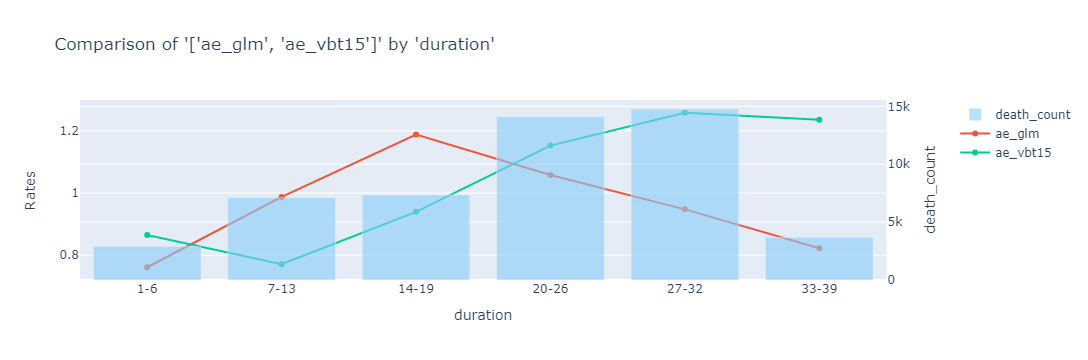

In [31]:
charters.compare_rates(
    df=model_data[model_data["insurance_plan"].isin(["UL", "ULSG"])],
    x_axis="duration",
    rates=["ae_glm", "ae_vbt15"],
    weights=["exp_amt_glm", "exp_amt_vbt15"],
    secondary="death_count",
    x_bins=6,
    display=True,
)

 2024-06-21 19:21:26 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


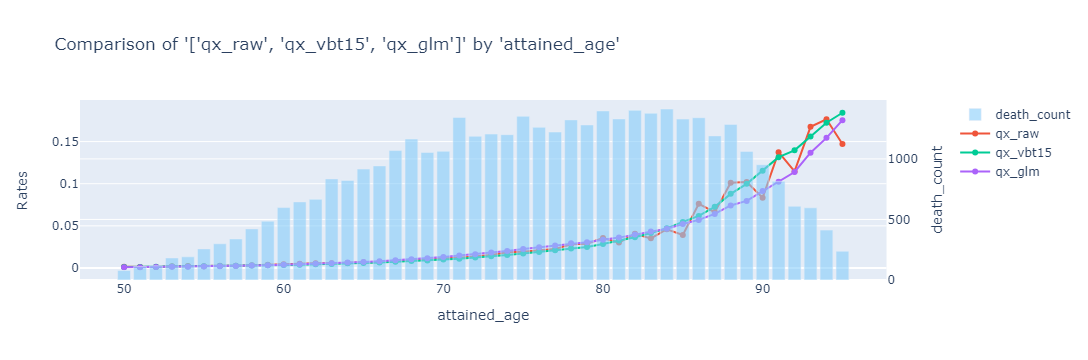

In [32]:
charters.compare_rates(
    model_data[model_data["insurance_plan"].isin(["UL"])],
    x_axis="attained_age",
    rates=["qx_raw", "qx_vbt15", "qx_glm"],
    weights=["amount_exposed"],
    secondary="death_count",
    y_log=False,
)

In [33]:
charters.pdp(
    model=GLM.model,
    df=md_encoded,
    x_axis="class_enh",
    mapping=mapping,
    weight="amount_exposed",
)

 2024-06-21 19:21:27 | morai.experience.charters | INFO     | Model: [GLMResultsWrapper] for partial dependence plot. 
 2024-06-21 19:21:27 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-21 19:21:27 | morai.experience.charters | INFO     | x_axis: [class_enh] type: [passthrough] 
 2024-06-21 19:21:27 | morai.experience.charters | INFO     | Creating 11 predictions. 


Processing:   0%|          | 0/11 [00:00<?, ?combo/s]

In [34]:
charters.target(
    df=model_data.loc[X_train.index],
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_glm"],
).show()

 2024-06-21 19:21:31 | morai.experience.charters | INFO     | Creating '10' target plots. 


In [35]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_glm"],
).show()

 2024-06-21 19:21:31 | morai.experience.charters | INFO     | Creating '10' target plots. 


## Linear Regression

**Feature Preprocessing:**
- Linear regression needs all features to be numeric.

In [35]:
model_name = "lr"

In [36]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
)

 2024-06-21 03:30:00 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-21 03:30:00 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-21 03:30:00 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['observation_year', 'duration', 'attained_age'] 
 2024-06-21 03:30:00 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['sex', 'smoker_status'] 
 2024-06-21 03:30:01 | morai.forecast.preprocessors | INFO     | nominal - one hot encoded: ['face_amount_band', 'insurance_plan', 'class_enh'] 


In [37]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [38]:
from sklearn import linear_model

if model_build:
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train, sample_weight=weights_train)
if model_load:
    model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(model)}")
if model_save:
    joblib.dump(model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(model)}")

model_params = {"weights": True}
model_params.update(model.get_params())

 2024-06-21 03:30:04 | __main__ | INFO     | saved model 'lr' 


In [39]:
predictions = model.predict(X)

In [40]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [41]:
importance = get_importance(features=X.columns, values=model.coef_)

In [42]:
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=model.predict(X_test),
    weights_test=weights_test,
    model=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

 2024-06-21 03:30:06 | morai.forecast.metrics | INFO     | Adding model 'lr' 


In [43]:
charters.compare_rates(
    model_data,
    x_axis="attained_age",
    rates=["qx_raw", "qx_vbt15", "qx_lr"],
    weights=["amount_exposed"],
    secondary="death_count",
)

 2024-06-21 03:30:06 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


In [44]:
charters.pdp(
    model=model,
    df=md_encoded,
    x_axis="insurance_plan",
    mapping=mapping,
    weight="amount_exposed",
)

 2024-06-21 03:30:07 | morai.experience.charters | INFO     | Model: [LinearRegression] for partial dependence plot. 
 2024-06-21 03:30:07 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-21 03:30:07 | morai.experience.charters | INFO     | x_axis: [insurance_plan] type: [passthrough] 
 2024-06-21 03:30:07 | morai.experience.charters | INFO     | Creating 6 predictions. 


Processing:   0%|          | 0/6 [00:00<?, ?combo/s]

In [45]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

In [46]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_lr"],
)

 2024-06-21 03:30:14 | morai.experience.charters | INFO     | Creating '9' target plots. 


## Decision Tree

**Feature Preprocessing:**
  - Tree is using ordinal as there is no categorical for this implementation of decision tree
  - Scaling is not necessary in decision trees as the splits are done at certain points and not scaled

In [198]:
model_name = "tree"

In [199]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    preset="tree",
)

 2024-06-21 19:07:51 | morai.forecast.preprocessors | INFO     | using 'tree' preset which doesn't need to use 'nominal' or 'ohe' and instead uses 'ordinal' 
 2024-06-21 19:07:51 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-21 19:07:51 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-21 19:07:51 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['duration', 'attained_age', 'observation_year'] 
 2024-06-21 19:07:51 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['sex', 'smoker_status', 'insurance_plan', 'face_amount_band', 'class_enh'] 


In [200]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [201]:
from sklearn.tree import DecisionTreeRegressor

if model_build:
    model = DecisionTreeRegressor(max_depth=6)
    model.fit(X_train, y_train, sample_weight=weights_train)
if model_load:
    model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(model)}")
if model_save:
    joblib.dump(model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(model)}")
model_params = {"weights": True}
model_params.update(model.get_params())

 2024-06-21 19:07:54 | __main__ | INFO     | saved model 'tree'. type: <class 'sklearn.tree._classes.DecisionTreeRegressor'> 


In [202]:
predictions = model.predict(X)

In [203]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [53]:
importance = get_importance(features=X.columns, values=model.feature_importances_)

In [54]:
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=model.predict(X_test),
    weights_test=weights_test,
    model=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

 2024-06-21 03:30:20 | morai.forecast.metrics | INFO     | Adding model 'tree' 


In [55]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

 2024-06-21 19:09:41 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


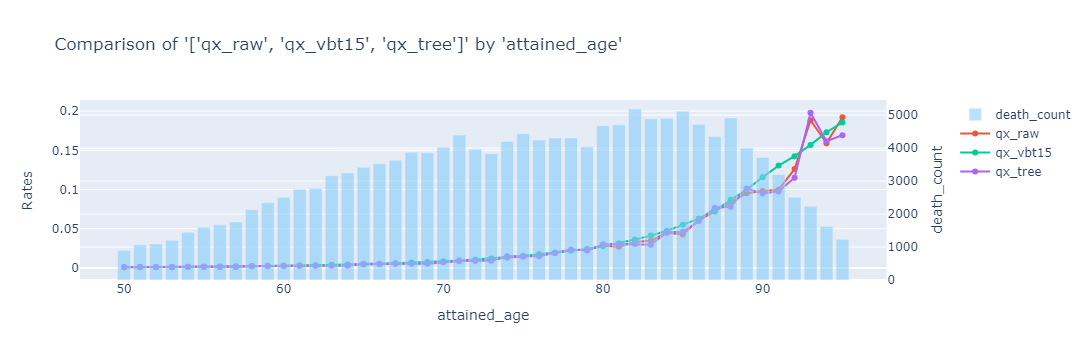

In [208]:
charters.compare_rates(
    model_data,
    x_axis="attained_age",
    rates=["qx_raw", "qx_vbt15", "qx_tree"],
    weights=["amount_exposed"],
    secondary="death_count",
)

In [57]:
charters.pdp(
    model=model,
    df=md_encoded,
    x_axis="observation_year",
    line_color="sex",
    mapping=mapping,
    weight="amount_exposed",
)

 2024-06-21 03:30:21 | morai.experience.charters | INFO     | Model: [DecisionTreeRegressor] for partial dependence plot. 
 2024-06-21 03:30:21 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-21 03:30:21 | morai.experience.charters | INFO     | x_axis: [observation_year] type: [passthrough] 
 2024-06-21 03:30:21 | morai.experience.charters | INFO     | Line feature: [sex] type: [ordinal] 
 2024-06-21 03:30:21 | morai.experience.charters | INFO     | Creating 16 predictions. 


Processing:   0%|          | 0/16 [00:00<?, ?combo/s]

 2024-06-21 19:09:22 | morai.experience.charters | INFO     | Creating '9' target plots. 


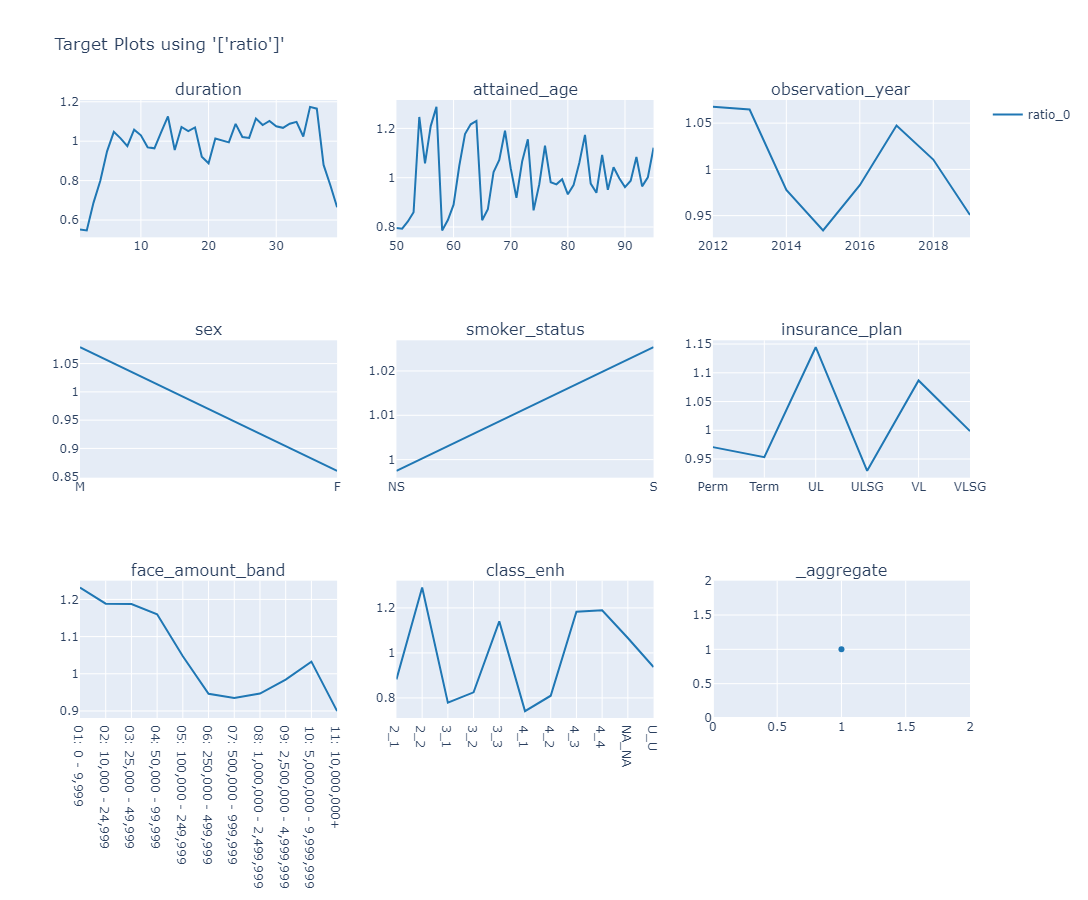

In [207]:
charters.target(
    df=model_data.loc[X_train.index],
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_tree"],
).show()

In [58]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_tree"],
).show()

 2024-06-21 03:30:24 | morai.experience.charters | INFO     | Creating '9' target plots. 


## Random Forest

**Feature Preprocessing:**
  - Tree is using ordinal as there is no categorical for this implementation of decision tree
  - Scaling is not necessary in decision trees as the splits are done at certain points and not scaled

**Model Characteristics**
  - Random Forest is good at finding non-linear relationships and is a `bagging` type model which limits overfitting.

In [34]:
model_name = "rf"

In [35]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    preset="tree",
)

 2024-06-21 15:36:54 | morai.forecast.preprocessors | INFO     | using 'tree' preset which doesn't need to use 'nominal' or 'ohe' and instead uses 'ordinal' 
 2024-06-21 15:36:54 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-21 15:36:54 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-21 15:36:54 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['duration', 'attained_age', 'observation_year'] 
 2024-06-21 15:36:54 | morai.forecast.preprocessors | INFO     | ordinal - ordinal encoded: ['sex', 'smoker_status', 'insurance_plan', 'face_amount_band', 'class_enh'] 


In [36]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [38]:
from sklearn.ensemble import RandomForestRegressor

if model_build:
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=5,
        oob_score=True,
        random_state=42,
    )

    model.fit(X_train, y_train, sample_weight=weights_train)
if model_load:
    model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(model)}")
if model_save:
    joblib.dump(model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(model)}")

model_params = {"weights": True}
model_params.update(model.get_params())

 2024-06-21 15:39:24 | __main__ | INFO     | saved model 'rf' 


In [39]:
predictions = model.predict(X)

In [40]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [41]:
importance = get_importance(features=X.columns, values=model.feature_importances_)

In [42]:
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=model.predict(X_test),
    weights_test=weights_test,
    model=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

 2024-06-21 15:42:05 | morai.forecast.metrics | INFO     | Adding model 'rf' 


In [43]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

In [44]:
charters.compare_rates(
    model_data,
    x_axis="attained_age",
    rates=["qx_raw", "qx_rf", "qx_vbt15"],
    weights=["amount_exposed"],
    secondary="death_count",
    x_bins=5,
    y_log=False,
)

 2024-06-21 15:42:09 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 
 2024-06-21 15:42:09 | morai.experience.charters | INFO     | Binning feature: [attained_age] with 5 bins 


In [45]:
charters.compare_rates(
    df=model_data[model_data["insurance_plan"].isin(["UL", "ULSG"])],
    x_axis="duration",
    rates=["ae_rf", "ae_vbt15"],
    weights=["exp_amt_rf", "exp_amt_vbt15"],
    secondary="death_count",
    x_bins=6,
    display=True,
)

 2024-06-21 15:42:09 | morai.experience.charters | INFO     | Binning feature: [duration] with 6 bins 


This shows that the perm product is not too high when accounting for the other variables

In [46]:
charters.pdp(
    model=model,
    df=md_encoded,
    x_axis="insurance_plan",
    weight="amount_exposed",
    secondary="death_count",
    mapping=mapping,
    display=True,
)

 2024-06-21 15:42:10 | morai.experience.charters | INFO     | Model: [RandomForestRegressor] for partial dependence plot. 
 2024-06-21 15:42:10 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-21 15:42:10 | morai.experience.charters | INFO     | x_axis: [insurance_plan] type: [passthrough] 
 2024-06-21 15:42:10 | morai.experience.charters | INFO     | Creating 6 predictions. 


Processing:   0%|          | 0/6 [00:00<?, ?combo/s]

 2024-06-21 15:43:45 | morai.experience.charters | INFO     | Adding secondary to chart: [death_count] 


In [71]:
charters.pdp(
    model=model,
    df=md_encoded[md_encoded["insurance_plan"].isin([2, 3])],
    x_axis="duration",
    line_color="class_enh",
    weight="amount_exposed",
    secondary="death_count",
    mapping=mapping,
    display=True,
    n_jobs=-1,
)

 2024-06-21 03:36:57 | morai.experience.charters | INFO     | Model: [RandomForestRegressor] for partial dependence plot. 
 2024-06-21 03:36:57 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-21 03:36:57 | morai.experience.charters | INFO     | x_axis: [duration] type: [passthrough] 
 2024-06-21 03:36:57 | morai.experience.charters | INFO     | Line feature: [class_enh] type: [ordinal] 
 2024-06-21 03:36:57 | morai.experience.charters | INFO     | Creating 429 predictions. 
 2024-06-21 03:36:57 | morai.experience.charters | INFO     | Running '7' cores for parallel processing. 


Processing:   0%|          | 0/429 [00:00<?, ?combo/s]

 2024-06-21 03:42:17 | morai.experience.charters | INFO     | Adding secondary to chart: [death_count] 


This shows there may be something with the data that there is an uptick in 2019. It also shows a similar pattern for all the products. Granted it is a random forest model so there may be some influence in the prediction

In [47]:
charters.pdp(
    model=model,
    df=md_encoded,
    x_axis="observation_year",
    line_color="insurance_plan",
    weight="amount_exposed",
    secondary="death_count",
    mapping=mapping,
    display=True,
    n_jobs=-1,
)

 2024-06-21 15:43:45 | morai.experience.charters | INFO     | Model: [RandomForestRegressor] for partial dependence plot. 
 2024-06-21 15:43:45 | morai.experience.charters | INFO     | Weights: [amount_exposed] 
 2024-06-21 15:43:45 | morai.experience.charters | INFO     | x_axis: [observation_year] type: [passthrough] 
 2024-06-21 15:43:45 | morai.experience.charters | INFO     | Line feature: [insurance_plan] type: [ordinal] 
 2024-06-21 15:43:45 | morai.experience.charters | INFO     | Creating 48 predictions. 
 2024-06-21 15:43:45 | morai.experience.charters | INFO     | Running '7' cores for parallel processing. 


Processing:   0%|          | 0/48 [00:00<?, ?combo/s]

 2024-06-21 15:46:07 | morai.experience.charters | INFO     | Adding secondary to chart: [death_count] 


 2024-06-21 04:06:51 | morai.experience.charters | INFO     | Creating '9' target plots. 


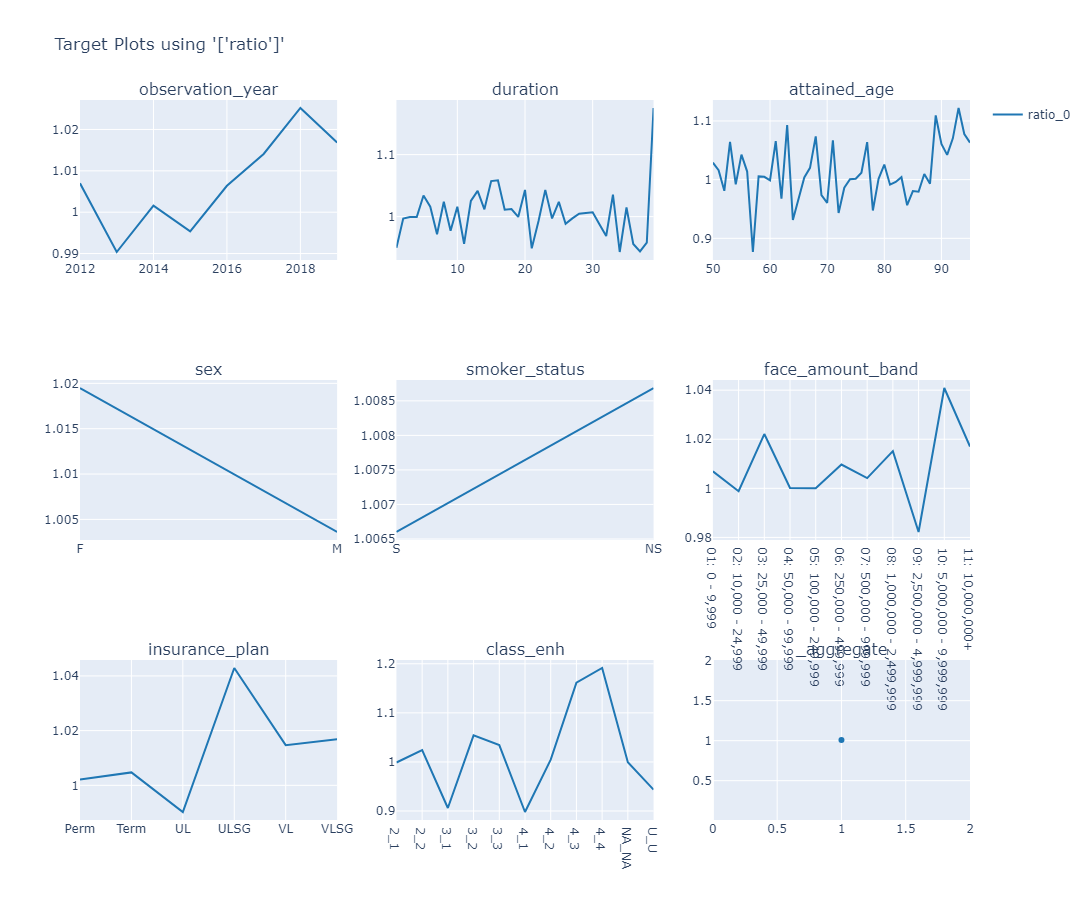

In [125]:
x_data = X_train
x_data['y_actual'] = y_train * weights_train
x_data['y_predict'] = model.predict(X_train) * weights_train

charters.target(
    df=x_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["y_actual"],
    denominator=["y_predict"],
).show()

 2024-06-21 03:56:37 | morai.experience.charters | INFO     | Creating '11' target plots. 


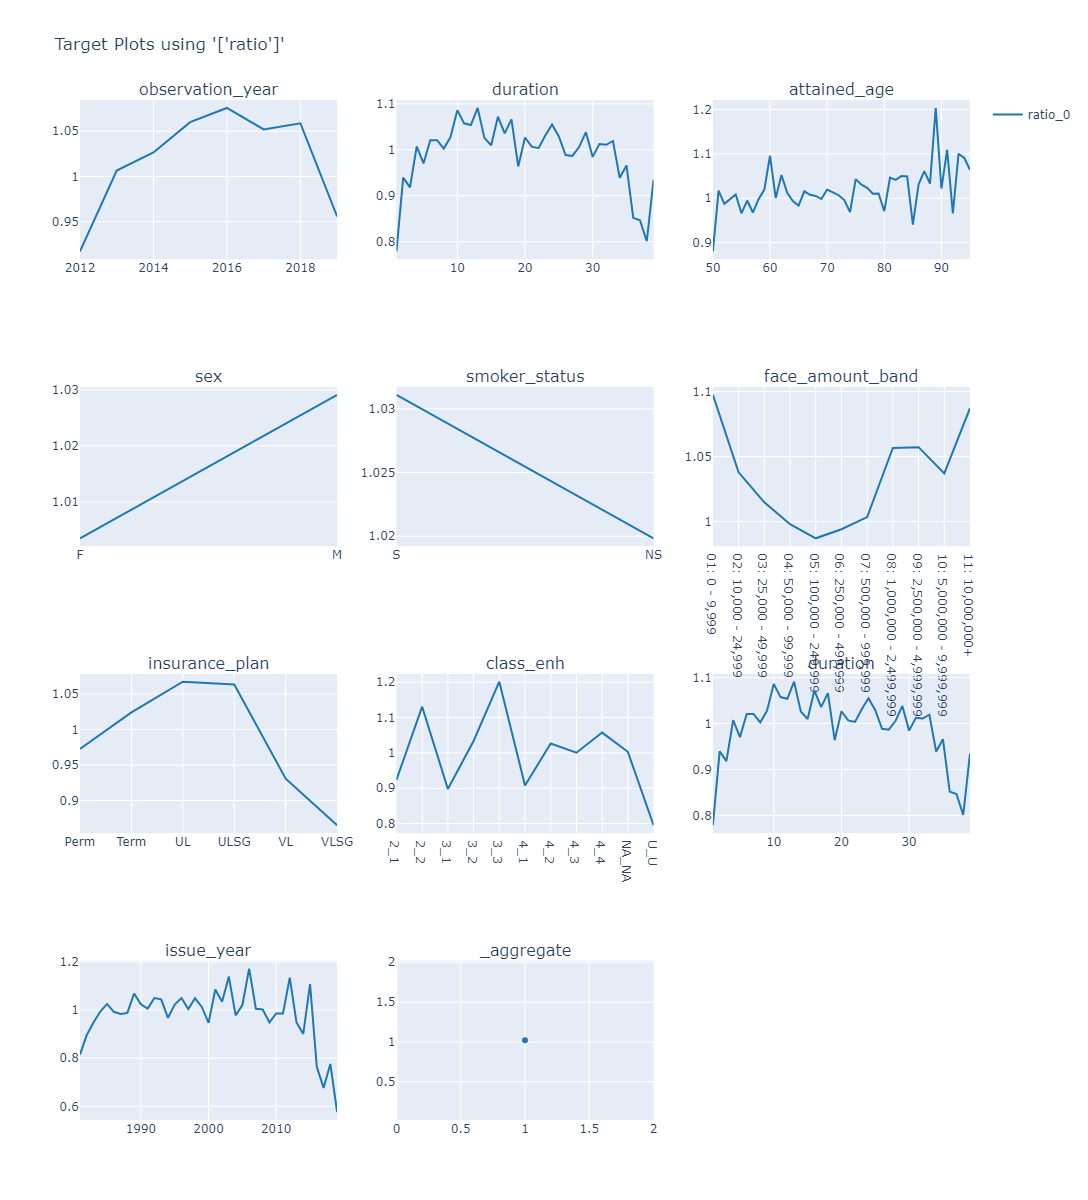

In [112]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features + ["duration", "issue_year"],
    numerator=["death_claim_amount"],
    denominator=["exp_amt_rf"],
).show()

## LightGBM

**Feature Preprocessing:**
- LightGBM doesn't need all numeric variables and can handle categorical

In [74]:
model_name = "lgb"

In [75]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    preset="pass",
)

 2024-06-21 00:17:46 | morai.forecast.preprocessors | INFO     | using 'pass' preset which makes all features passthrough 
 2024-06-21 00:17:46 | morai.forecast.preprocessors | INFO     | model target: ['qx_raw'] 
 2024-06-21 00:17:46 | morai.forecast.preprocessors | INFO     | model weights: ['amount_exposed'] 
 2024-06-21 00:17:46 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['duration', 'observation_year', 'attained_age', 'sex', 'smoker_status', 'face_amount_band', 'class_enh', 'insurance_plan'] 


In [76]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [77]:
import lightgbm as lgb

if model_build:
    params = {
        "boosting_type": "gbdt",
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 31,
        "learning_rate": 0.05,
        "feature_fraction": 0.5,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
    }

    train_data = lgb.Dataset(X_train, label=y_train, weight=weights_train)
    model = lgb.train(params, train_data)
if model_load:
    model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(model)}")
if model_save:
    joblib.dump(model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(model)}")

model_params = {"weights": True}
model_params.update(model.params)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.408376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 133
[LightGBM] [Info] Number of data points in the train set: 872600, number of used features: 8
[LightGBM] [Info] Start training from score 0.004721
 2024-06-21 00:37:11 | __main__ | INFO     | saved model 'lgb' 


In [78]:
predictions = model.predict(X)

In [79]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [80]:
importance = get_importance(
    features=X.columns, values=model.feature_importance(importance_type="gain")
)

In [81]:
# get results
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=model.predict(X_test),
    weights_test=weights_test,
    model=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

 2024-06-21 00:37:14 | morai.forecast.metrics | INFO     | Adding model 'lgb' 


In [82]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

In [83]:
charters.compare_rates(
    model_data[model_data["insurance_plan"].isin(["UL"])],
    x_axis="insurance_plan",
    rates=["qx_raw", "qx_lgb", "qx_vbt15"],
    weights=["amount_exposed"],
    secondary="death_count",
)

 2024-06-21 00:37:14 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


In [84]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_lgb"],
).show()

 2024-06-21 00:37:14 | morai.experience.charters | INFO     | Creating '9' target plots. 


In [85]:
# lgb.plot_tree(model, tree_index=0, figsize=(20, 10))
# plt.show()

## XGBoost

**Feature Preprocessing:**
- XGBoost doesn't need all numeric variables and can handle categorical

In [ ]:
model_name = "xgb"

In [ ]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    preset="pass",
)

In [ ]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

if model_build:
    model = XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        max_depth=6,
        eta=0.05,
        subsample=0.8,
        colsample_bytree=0.5,
        enable_categorical=True,
    )

    model.fit(X_train, y_train, sample_weight=weights_train)
if model_load:
    model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(model)}")
if model_save:
    joblib.dump(model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(model)}")

model_params = {"weights": True}
model_params.update(model.get_params())

In [ ]:
predictions = model.predict(X)

In [ ]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [ ]:
importance = get_importance(features=X.columns, values=model.feature_importances_)

In [ ]:
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=model.predict(X_test),
    weights_test=weights_test,
    model=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

In [ ]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

In [ ]:
charters.compare_rates(
    model_data,
    x_axis="insurance_plan",
    rates=["qx_raw", "qx_xgb", "qx_vbt15"],
    weights=["amount_exposed"],
    secondary="death_count",
)

In [ ]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_xgb"],
).show()

In [ ]:
# lgb.plot_tree(bst, tree_index=0, figsize=(20, 10))
# plt.show()

## CatBoost

**Feature Preprocessing:**
- CatBoost doesn't need all numeric variables and can handle categorical

In [ ]:
model_name = "cat"

In [ ]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
    preset="pass",
)

In [ ]:
X = preprocess_dict["X"]
y = preprocess_dict["y"]
weights = preprocess_dict["weights"]
mapping = preprocess_dict["mapping"]
md_encoded = preprocess_dict["md_encoded"]
model_features = preprocess_dict["model_features"]

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, weights, random_state=0, test_size=0.2
)

In [ ]:
cat_features = feature_dict["ordinal"] + feature_dict["ohe"] + feature_dict["nominal"]
cat_features = list(set(cat_features) & set(model_features))

In [ ]:
from catboost import CatBoostRegressor

if model_build:
    model = CatBoostRegressor(
        iterations=1000, learning_rate=.1, depth=7, cat_features=cat_features
    )
    model.fit(X_train, y_train, sample_weight=weights_train, verbose=0)
if model_load:
    model = joblib.load(f"files/models/{model_name}.joblib")
    logger.info(f"loaded model '{model_name}'. type: {type(model)}")
if model_save:
    joblib.dump(model, f"files/models/{model_name}.joblib")
    logger.info(f"saved model '{model_name}'. type: {type(model)}")

model_params = {"weights": True}
model_params.update(model.get_params())

In [ ]:
predictions = model.predict(X)

In [ ]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [ ]:
importance = get_importance(features=X.columns, values=model.feature_importances_)

In [ ]:
scorecard = model_results.get_scorecard(
    y_true_train=y_train,
    y_pred_train=model.predict(X_train),
    weights_train=weights_train,
    y_true_test=y_test,
    y_pred_test=model.predict(X_test),
    weights_test=weights_test,
    model=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=preprocess_dict,
    model_params=model_params,
    scorecard=scorecard,
    importance=importance,
)

In [ ]:
charters.chart(
    df=importance, x_axis="feature", y_axis="importance", type="bar", y_sort=True
)

In [ ]:
charters.compare_rates(
    model_data,
    x_axis="attained_age",
    rates=["qx_raw", "qx_cat", "qx_vbt15"],
    weights=["amount_exposed"],
    secondary="death_count",
)

In [ ]:
charters.pdp(
    model=model,
    df=md_encoded,
    x_axis="class_enh",
    weight="amount_exposed",
    mapping=mapping,
    display=True,
)

In [ ]:
charters.target(
    df=model_data,
    target="ratio",
    cols=3,
    features=model_features,
    numerator=["death_claim_amount"],
    denominator=["exp_amt_cat"],
).show()

## Lee Carter

The Lee-Carter model is formulated as follows:

$$\log(m_{x,t}) = a_{x} + b_{x}k_{t} + \epsilon_{x,t}$$

source: https://en.wikipedia.org/wiki/Lee%E2%80%93Carter_model

Where:
- $m_{x,t}$ is the _matrix mortality rate_ at age $x$ in year $t$
- $a_{x}$ describes the general _shape_ of mortality at age $x$ (mean of the time-averaged logs of the central mortality rate at age $x$). This is known as the _age effect_ on mortality.
- $b_{x}$ measures the change in the rates at age $x$ due to a change in the underlying time trend, $k_{t}$.
- $k_{t}$ reflects the effect of the time trend, $t$, on mortality.
- $\epsilon_{x,t}$ are i.i.d. normal random variables with zero means and constant variance, $\sigma^{2}$.

In [111]:
model_name = "lc"

In [112]:
model_params = {"weights": True}
model = models.LeeCarter()

 2024-06-21 00:39:50 | morai.forecast.models | INFO     | initialized LeeCarter 


In [113]:
lc_df = model.structure_df(model_data)

 2024-06-21 00:39:50 | morai.forecast.models | INFO     | grouping data by age and year 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | calculating qx_raw rates using death_claim_amount and amount_exposed 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | there were 0 rates over 1 that were capped. 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | crude_df shape: (368, 5) 


In [114]:
lc_df = model.fit(lc_df)

 2024-06-21 00:39:50 | morai.forecast.models | INFO     | creating Lee Carter model with qx_raw rates... 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | age range: 50, 95 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | year range: 2012, 2019 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | calculating qx_lc = exp(a_x + b_x * k_t) 
 2024-06-21 00:39:50 | morai.forecast.models | INFO     | adding qx_lc to lc_df 


In [115]:
model_data = model.map(model_data)

 2024-06-21 00:39:50 | morai.forecast.models | INFO     | mapping qx_lc to df 


In [116]:
lcf_df = model.forecast(years=5)

 2024-06-21 00:39:51 | morai.forecast.models | INFO     | forecasting qx_lc using deterministic random walk... 


In [117]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [118]:
scorecard = model_results.get_scorecard(
    y_true_train=model_data["death_claim_amount"],
    y_pred_train=model_data[f"exp_amt_{model_name}"],
    weights_train=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=None,
    model_params=model_params,
    scorecard=scorecard,
    importance=None,
)

 2024-06-21 00:39:51 | morai.forecast.metrics | INFO     | Adding model 'lc' 


Average log qx shows that mortality rates increase by age

In [119]:
charters.chart(
    df=model.a_x.reset_index(),
    x_axis="attained_age",
    y_axis=0,
    color=None,
    type="line",
    title="Average of log(qx)",
    labels={"attained_age": "attained_age", "0": "log_qx"},
)

In [120]:
charters.chart(
    df=model.k_t.reset_index(),
    x_axis="observation_year",
    y_axis=0,
    color=None,
    type="line",
    title="Time Trend of Mortality",
    labels={"observation_year": "observation_year", "0": "k_t"},
)

In [121]:
charters.chart(
    df=model.b_x.reset_index(),
    x_axis="attained_age",
    y_axis=0,
    color=None,
    type="line",
    title="Change in the Rate per Age with Respect to each Year",
    labels={"attained_age": "attained_age", "0": "b_x"},
)

In [122]:
charters.compare_rates(
    model_data,
    x_axis="observation_year",
    rates=["qx_raw", "qx_lc"],
    weights=["amount_exposed"],
    secondary="amount_exposed",
)

 2024-06-21 00:39:51 | morai.experience.charters | INFO     | The weights list is 1 long and should be 2 long. Using the first weight for all weights. 


## Cairns-Blake-Dowd Model

The Cairns-Blake-Dowd (CBD) model is a stochastic mortality model, and a variant of the Lee-Carter mortality model. It is designed with longevity risk in mind, particularly attempting to understand and forecast mortality at older ages.

The model is in the following form:

$$\text{logit}(_{t}q_{x}) = \kappa_{t}^{(1)} + (x - \bar{x})\kappa_{t}^{(2)}$$

- $\text{logit}(\alpha) = \log\big(\frac{\alpha}{1-\alpha}\big)$
- $\kappa_{t}^{(1)}$  is the _level_ factor, varying with respect to year $t \in (t_{1}, t_{2}, \dots, t_{q})$
- $\kappa_{t}^{(2)}$  is the _slope_ factor, varying with respect to year $t \in (t_{1}, t_{2}, \dots, t_{q})$
- $x$ is the age group, $x \in (x_{1}, x_{2}, \dots, x_{p})$
- $\bar{x}$ is the average of the age group
- $_{t}q_{x}$ is the probability an individual aged $x$ last birthday dies before age $x+t$

We will be using method of least-squares to get estimates $\hat{\kappa}^{(1)}$ and $\hat{\kappa}^{(2)}$.

Further information:
- https://www.actuaries.org/AFIR/Colloquia/Rome2/Cairns_Blake_Dowd.pdf - further discussion on the merits of the CBD model (such as age-period cohort effects and further extensions to the CBD model).

In [123]:
model_name = "cbd"

In [124]:
model_params = {"weights": True}
model = models.CBD()

 2024-06-21 00:39:52 | morai.forecast.models | INFO     | initialized CBD 


In [125]:
cbd_df = model.structure_df(model_data)

 2024-06-21 00:39:52 | morai.forecast.models | INFO     | grouping data by age and year 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | calculating qx_raw rates using death_claim_amount and amount_exposed 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | there were 0 rates over 1 that were capped. 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | cbd_df shape: (368, 5) 


In [126]:
cbd_df = model.fit(cbd_df)

 2024-06-21 00:39:52 | morai.forecast.models | INFO     | creating CBD model with qx_raw rates... 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | age range: 50, 95 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | average age: 72.5 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | year range: 2012, 2019 
 2024-06-21 00:39:52 | morai.forecast.models | INFO     | adding qx_cbd to cbd_df 


In [127]:
model_data = model.map(model_data)

 2024-06-21 00:39:52 | morai.forecast.models | INFO     | mapping qx_cbd to df 


In [128]:
cbdf_df = model.forecast(years=5)

 2024-06-21 00:39:52 | morai.forecast.models | INFO     | forecasting qx_cbd using deterministic random walk... 


In [129]:
model_data = add_qx_exp_ae(model_data, predictions, model_name)

In [130]:
scorecard = model_results.get_scorecard(
    y_true_train=model_data["death_claim_amount"],
    y_pred_train=model_data[f"exp_amt_{model_name}"],
    weights_train=None,
)
model_results.add_model(
    model_name=model_name,
    data_path=pl_parquet_path,
    data_shape=model_data.shape,
    preprocess_dict=None,
    model_params=model_params,
    scorecard=scorecard,
    importance=None,
)

 2024-06-21 00:39:52 | morai.forecast.metrics | INFO     | Adding model 'cbd' 


In [131]:
# shape shows the impact of time on mortality
charters.chart(
    df=pd.concat([model.k_t_1, model.k_1_f]).reset_index(),
    x_axis=model.year_col,
    y_axis=0,
    color=None,
    type="line",
    title="Shape Component by year",
    labels={"0": "k_t_1"},
)

In [132]:
# slope shows if the impact of time is different by year
charters.chart(
    df=pd.concat([model.k_t_2, model.k_2_f]).reset_index(),
    x_axis=model.year_col,
    y_axis=0,
    color=None,
    type="line",
    title="Slope Component by year",
    labels={"0": "k_t_2"},
)

In [133]:
charters.compare_rates(
    model_data,
    x_axis="observation_year",
    rates=["qx_raw", "qx_cbd"],
    weights=["amount_exposed"],
    secondary="amount_exposed",
)

 2024-06-21 00:39:53 | morai.experience.charters | INFO     | The weights list is 1 long and should be 2 long. Using the first weight for all weights. 


# Model Results

In [134]:
original_float_format = pd.options.display.float_format
pd.options.display.float_format = "{:,.6f}".format  # Increase to 10 decimal places
model_results.scorecard.sort_values(by=("test", "r2_score"), ascending=False)

model_name    train                                                     \
                   ae    smape r2_score root_mean_squared_error    shape   
1        glm 1.000000 1.926310 0.130557          217,740.465158   872600   
5        lgb 1.002370 1.927722 0.358278          187,064.775423   872600   
6        xgb 0.999251 1.925957 0.291694          196,530.065540   872600   
3       tree 1.000000 1.930459 0.337959          190,003.184004   872600   
7        cat 1.002644 1.924196 0.477648          168,771.986097   872600   
4         rf 0.994955 1.911006 0.580842          151,184.469301   872600   
2         lr 1.000000 1.930750 0.005198          232,909.311854   872600   
0      vbt15 0.918294 1.927851 0.126974          232,497.765666  1090750   
8         lc 1.030185 1.924356 0.377876          196,265.373647  1090750   
9        cbd 1.030185 1.924356 0.377876          196,265.373647  1090750   

                             test                                             \
                     aic       ae    smape  r2_score root_mean_squared_error   
1 148,957,640,134.299164 0.994102 1.925254  0.124024          213,740.188298   
5                    NaN 1.003487 1.926975  0.112866          215,097.156978   
6                    NaN 0.996743 1.925208  0.112164          215,182.300693   
3                    NaN 1.003019 1.929610  0.077115          219,388.527526   
7                    NaN 1.003476 1.923832  0.042693          223,442.457893   
4                    NaN 0.988936 1.916579  0.022387          225,799.823709   
2                    NaN 0.992439 1.929831 -0.000472          228,424.427935   
0                    NaN      NaN      NaN       NaN                     NaN   
8                    NaN      NaN      NaN       NaN                     NaN   
9                    NaN      NaN      NaN       NaN                     NaN   

                                         
                     aic          shape  
1 148,957,640,134.299164 218,150.000000  
5                    NaN 218,150.000000  
6                    NaN 218,150.000000  
3                    NaN 218,150.000000  
7                    NaN 218,150.000000  
4                    NaN 218,150.000000  
2                    NaN 218,150.000000  
0                    NaN            NaN  
8                    NaN            NaN  
9                    NaN            NaN

In [135]:
pd.options.display.float_format = original_float_format

In [ ]:
break

In [136]:
# write out results
model_results.save_model()
model_data.to_parquet("files/dataset/model_data.parquet")

 2024-06-21 00:39:53 | morai.forecast.metrics | INFO     | saving results to /workspace/github/morai/files/result/model_results.json 


In [22]:
# model_results = metrics.ModelResults(filepath='model_results.json')

 2024-06-20 03:43:50 | morai.forecast.metrics | INFO     | loading results from /workspace/github/morai/files/result/model_results.json 


In [60]:
rank_df = metrics.ae_rank(
    df=model_data[model_data["insurance_plan"].isin(["UL", "ULSG"])],
    features=model_features,
    actuals="death_claim_amount",
    expecteds="exp_amt_vbt15",
    exposures="amount_exposed",
)
rank_df.head()

 2024-06-20 04:02:02 | morai.forecast.metrics | INFO     | The total AE with exp_amt_vbt15 as E for dataset is 98.8% 


attribute attribute_value  death_claim_amount    exp_amt_vbt15  \
55        class_enh           NA_NA          2816075499 2,304,175,792.14   
49        class_enh             3_2          1043187659 1,447,713,841.21   
48        class_enh             3_1           405925432   676,392,253.98   
108  insurance_plan            ULSG          4009501882 4,547,867,538.55   
107  insurance_plan              UL          5101706680 4,677,286,392.35   

        amount_exposed   ae             a-e  exposure_pct  rank_issue  \
55  180,130,835,097.44 1.22  511,899,706.86          0.22           1   
49  119,159,341,515.07 0.72 -404,526,182.21          0.15           2   
48  103,503,617,127.96 0.60 -270,466,821.98          0.13           3   
108 471,008,178,707.62 0.88 -538,365,656.55          0.58           4   
107 346,601,046,061.14 1.09  424,420,287.65          0.42           8   

     rank_driver  rank_combined  
55             1              2  
49             2              4  
48             4              7  
108            5              9  
107            3             11

# Visualizations

 2024-06-20 04:00:56 | morai.experience.charters | INFO     | Calculating ratio using [death_claim_amount] and [amount_exposed] 


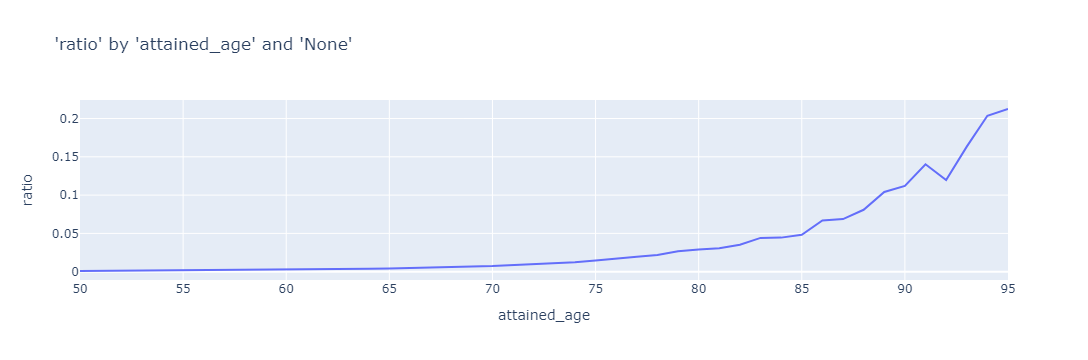

In [56]:
charters.chart(
    df=model_data,
    x_axis="attained_age",
    y_axis="ratio",
    color=None,
    type="line",
    numerator="death_claim_amount",
    denominator="amount_exposed",
)

 2024-06-20 05:22:06 | morai.experience.charters | INFO     | Calculating ratio using [death_claim_amount] and [amount_exposed] 
 2024-06-20 05:22:06 | morai.experience.charters | INFO     | Binning feature: [duration] with 5 bins 


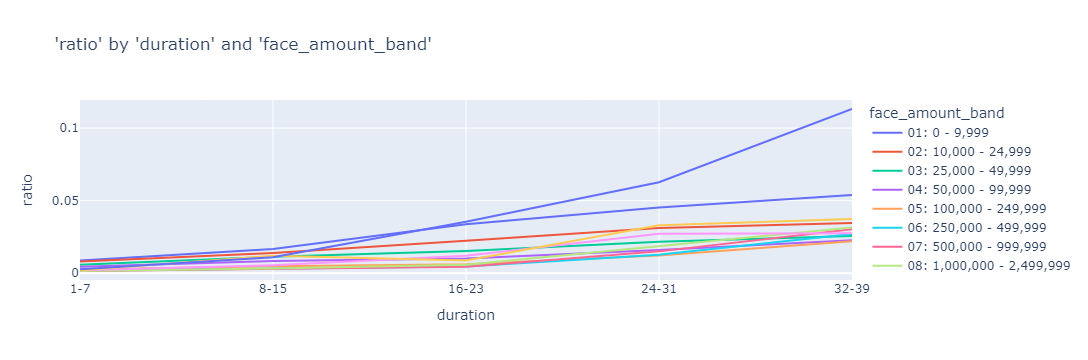

In [105]:
charters.chart(
    df=model_data,
    x_axis="duration",
    y_axis="ratio",
    color="face_amount_band",
    numerator="death_claim_amount",
    denominator="amount_exposed",    
    x_bins=5,
    type="line",
)

 2024-06-20 04:01:02 | morai.experience.charters | INFO     | Calculating ratio using [death_claim_amount] and [amount_exposed] 
 2024-06-20 04:01:02 | morai.experience.charters | INFO     | Binning feature: [duration] with 5 bins 


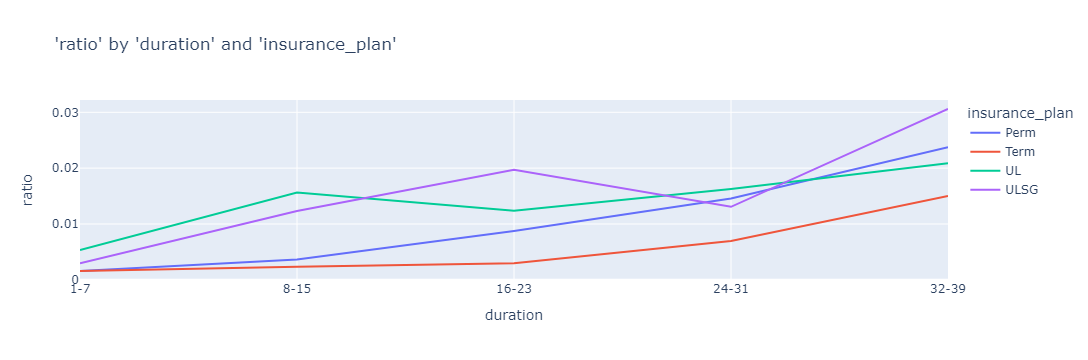

In [57]:
charters.chart(
    df=model_data[
        (model_data["attained_age"] > 50)
        & (model_data["attained_age"] < 90)
        & (model_data["insurance_plan"].isin(["Term", "UL", "Perm", "ULSG"]))
    ],
    x_axis="duration",
    color="insurance_plan",
    y_axis="ratio",
    type="line",
    numerator="death_claim_amount",
    denominator="amount_exposed",
    x_bins=5,
)

This shows that as duration goes up the class structure becomes more NA preferred class structure which has poor a/e

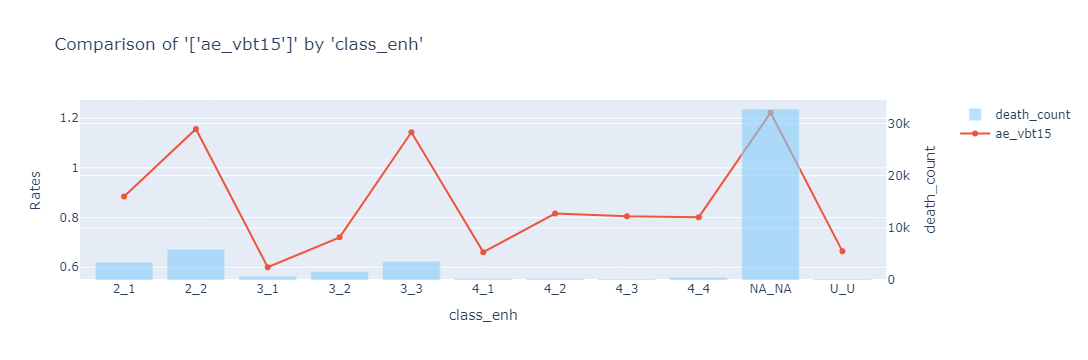

In [101]:
charters.compare_rates(
    df=model_data[model_data["insurance_plan"].isin(["UL", "ULSG"])],
    x_axis="class_enh",
    rates=["ae_vbt15"],
    weights=["exp_amt_vbt15"],
    secondary="death_count",
    display=True,
)

 2024-06-20 04:42:33 | morai.experience.charters | INFO     | Binning feature: [duration] with 5 bins 


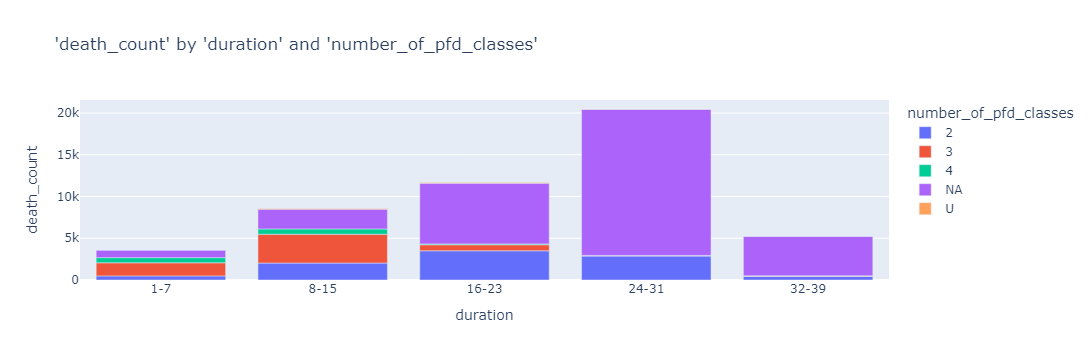

In [103]:
charters.chart(
    df=model_data[model_data["insurance_plan"].isin(["UL", "ULSG"])],
    x_axis="duration",
    y_axis="death_count",
    color="number_of_pfd_classes",
    x_bins=5,
    type="bar",
)

This shows the product sales by year

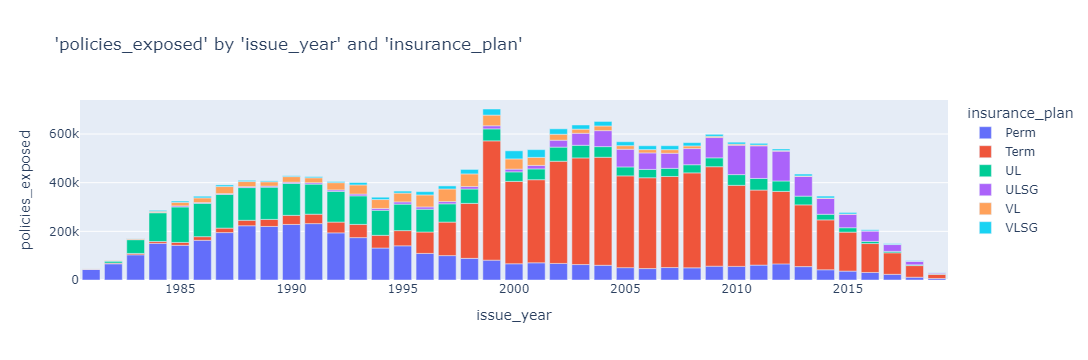

In [59]:
charters.chart(
    df=model_data,
    x_axis="issue_year",
    y_axis="policies_exposed",
    color="insurance_plan",
    type="bar",
)

In [ ]:
# charters.scatter(df=df, target="qx_raw", numeric=True, sample_nbr=1000).show()

# Reload

In [ ]:
importlib.reload(charters)

In [ ]:
importlib.reload(custom_logger)

In [ ]:
importlib.reload(models)

In [ ]:
importlib.reload(helpers)

In [ ]:
importlib.reload(metrics)

In [191]:
importlib.reload(preprocessors)

<module 'morai.forecast.preprocessors' from '/workspace/github/morai/morai/forecast/preprocessors.py'>

# Utilities

In [ ]:
helpers.memory_usage_jupyter(globals=globals()).head(10)

# Test